*Copyright (c) Cornac Authors. All rights reserved.*

*Licensed under the Apache 2.0 License.*

# Model Ensembling

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/cornac/blob/master/tutorials/model_ensembling.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/cornac/blob/master/tutorials/model_ensembling.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This notebook provides an example of how to ensemble multiple recommendation models in Cornac.

Ensemble models is a technique that combines the predictions of multiple models to produce a single prediction. The idea is that by combining the predictions of multiple models, we can improve the overall performance of the recommendation system.

We will use the MovieLens 100K dataset and ensemble 2 models.

** Note: ** This notebook requires the `scikit-learn` package. 

## 1. Setup

### Install required dependencies

In [2]:
! pip install seaborn scikit-learn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.data import Dataset
from cornac.models import BPR, WMF

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

/Users/darrylong/miniconda3/envs/gcmc-pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Prepare Experiment

### Loading Dataset

First, we load the MovieLens 100K dataset.

In [2]:
data = movielens.load_feedback(variant="100K") # load dataset
dataset = Dataset.from_uir(data) # convert to Dataset object

### Training BPR and WMF models

We will train two models: 

1. BPR (Bayesian Personalized Ranking)
2. WMF (Weighted Matrix Factorization)

In [3]:
# Train BPR model
bpr_model = BPR(k=10, max_iter=100, learning_rate=0.01, lambda_reg=0.001)
bpr_model.fit(dataset)

# Train WMF model
wmf_model = WMF(k=10, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,)
wmf_model.fit(dataset)

100%|██████████| 100/100 [00:05<00:00, 16.75it/s, loss=104]

Learning completed!


### Reviewing Individual Trained Models

These models are trained and evaluated individually. The scores of the models will be used to ensemble the models.

Let's see what the prediction scores of user index 0 looks like.
Take note that user index '0' may not correspond to user ID '0', depending on how the dataset is loaded.

This prints scores of all items for user index 0. The higher the score, the more likely the user will like the item.

In [12]:
# get item ids scores
print("BPR scores for user idx 0:", bpr_model.score(0)) # get BPR scores of user idx 0
print("WMF scores for user idx 0:", wmf_model.score(0)) # get WMF scores of user idx 0

BPR scores for user idx 0: [ 2.5407927   3.2257416  -0.90109813 ... -2.0262032  -2.0933206
 -2.1515543 ]
WMF scores for user idx 0: [3.5014405  3.467132   1.1731424  ... 0.23383346 0.2283108  0.23851925]


## 3. Perform Model Ensembling

Prepare the data for the ensemble model. We will use the predictions of the individual models as features for the ensemble model.

In [4]:
# Get all scores

scores_bpr = np.array([bpr_model.score(uid) for uid in range(dataset.num_users)])
scores_wmf = np.array([wmf_model.score(uid) for uid in range(dataset.num_users)])

scores_bpr = scores_bpr.flatten()
scores_wmf = scores_wmf.flatten()

print("BPR scores shape:", scores_bpr.shape)
print("WMF scores shape:", scores_wmf.shape)

X_train = np.array(2 * [(uid, iid) for iid in range(dataset.num_items) for uid in range(dataset.num_users)])
y_train = np.concatenate((scores_bpr, scores_wmf))

print(X_train.shape, y_train.shape)

BPR scores shape: (1586126,)
WMF scores shape: (1586126,)
(3172252, 2) (3172252,)


Next, we train this ensemble model.

We use a bagging ensemble model with a decision tree as the base estimator.



### Training models

In [5]:
base_model = DecisionTreeRegressor(random_state=42)
bagging_model = BaggingRegressor(base_model, n_estimators=10)
adaboost_model = AdaBoostRegressor(base_model, n_estimators=50)

randomforest_model = RandomForestRegressor(n_estimators=200, random_state=42)

# bagging_model.fit(X_train, y_train)
adaboost_model.fit(X_train, y_train)
randomforest_model.fit(X_train, y_train)





KeyboardInterrupt: 

## 4. New Model Prediction

### Prediction for a given input

In [35]:
print(bagging_model.predict([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]))

bagging_scores = bagging_model.predict([(uid, iid) for iid in range(dataset.num_items) for uid in range(dataset.num_users)])

print(bagging_scores.shape)

[ 3.06559531  0.56207841  3.2010407  -0.14485012  3.44872588]
(1586126,)


In [48]:
df = pd.DataFrame({
    'iid': 3 * [iid for iid in range(dataset.num_items) for _ in range(dataset.num_users)],
    'score': np.concatenate((scores_bpr, scores_wmf, bagging_scores)),
    'model': ['bpr'] * dataset.num_items * dataset.num_users + ['wmf'] * dataset.num_items * dataset.num_users + ['bagging'] * dataset.num_items * dataset.num_users,
})

# sns.scatterplot(x=df['iid'], y=df['score'], hue=df['model'])

Let's compare the scores of the ensemble model with the individual models.

<Axes: xlabel='iid', ylabel='score'>

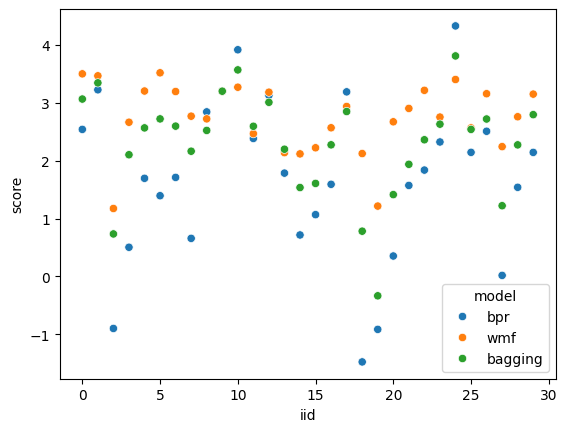

In [46]:
# Get first 30 items and visualize them.
sub_df = df[df['iid'] < 30]

sns.scatterplot(x=sub_df['iid'], y=sub_df['score'], hue=sub_df['model'])


### Obtaining top N items for each model

#### Using pandas DataFrame

The following code snippet shows how to obtain the top N items for each model using pandas.

Comparing top N items between models.

In [71]:
df.groupby('model')['score'].nlargest(5)

model           
bagging  4481023     8.245889
         4481456     7.779728
         3467460     7.250266
         4481708     7.174910
         4358095     7.161881
bpr      1308668    11.019190
         1308694    10.733021
         1308644    10.637164
         1309248    10.630405
         1308857    10.613405
wmf      2365249     5.502999
         1781595     5.485583
         3098601     5.450799
         2466169     5.442069
         2116313     5.357513
Name: score, dtype: float64

In [77]:
bagging_df = df[df['model'] == 'bagging'].nlargest(10, 'score')
print(bagging_df)

top_10_items = bagging_df['iid'].values
print(list(top_10_items))

          iid     score    model
4481023  1387  8.245889  bagging
4481456  1388  7.779728  bagging
3467460   313  7.250266  bagging
4481708  1388  7.174910  bagging
4358095  1257  7.161881  bagging
4480891  1387  7.018400  bagging
4672597  1591  6.968317  bagging
3693928   553  6.939213  bagging
4481500  1388  6.920802  bagging
4480920  1387  6.902302  bagging
[1387, 1388, 313, 1388, 1257, 1387, 1591, 553, 1388, 1387]
